In [1]:
import os
import shutil
from __future__ import print_function, division
import argparse
import gc
import warnings
import tensorflow as tf

# Do not use whole GPU memory, only 80%
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


import pandas as pd

import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras import backend as K
from keras.datasets import mnist
from keras import layers, models
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras_contrib.layers import InstanceNormalization
import matplotlib.pyplot as plt
import cv2
import sys
import random
from keras.losses import binary_crossentropy
import numpy as np
from keras.layers import LeakyReLU
gc.enable()  # memory is tight


print(os.listdir('data2/images'))


Using TensorFlow backend.


['comic_blurred_405', 'comic', 'comic_405', 'real', 'comic_blurred']


In [2]:
REAL_IMG_DIR = "data/images/real"
COMIC_IMG_DIR = "data2/images/comic_405"
COMIC_BLURRED_IMG_DIR = "data2/images/comic_blurred_405"

CHECKPOINTS_DIR = "data2/checkpoints"

G_WEIGHTS_PATH = os.path.join(CHECKPOINTS_DIR, "G_weights.best.hdf5")
G_PRETRAIN_WEIGHTS_PATH = os.path.join(CHECKPOINTS_DIR, "G_weights_pretrain.best.hdf5")
D_WEIGHTS_PATH = os.path.join(CHECKPOINTS_DIR, "D_weights.best.hdf5")
D_PRETRAIN_WEIGHTS_PATH = os.path.join(CHECKPOINTS_DIR, "D_weights_pretrain.best.hdf5")

PRETRAIN_FIT_HISTORY_PATH = os.path.join(CHECKPOINTS_DIR, "PRETRAIN_history.csv")
PRETRAIN_DISCRIMINATOR_FIT_HISTORY_PATH = os.path.join(CHECKPOINTS_DIR, "PRETRAIN_D_history.csv")
ADV_FIT_HISTORY_PATH = os.path.join(CHECKPOINTS_DIR, "ADV_history.csv")
PRETRAIN_FIT_HISTORY_IMGS = os.path.join(CHECKPOINTS_DIR, 'pretrain_images')
ADV_FIT_HISTORY_IMGS = os.path.join(CHECKPOINTS_DIR, 'adv_images')

NUMBER_OF_TEST_REAL_IMAGES = 5000
NUMBER_OF_VALIDATION_REAL_IMAGES = 5000
NUMBER_OF_VALIDATION_COMIC_IMAGES = 100
NUMBER_OF_VALIDATION_COMIC_BLURRED_IMAGES = 100

IMG_SIZE = 384
PRETRAIN_VALIDATION_IMGS_NUM_TO_USE = 200
ADVERSARIAL_VALIDATION_IMGS_NUM_TO_USE = 200
PRETRAIN_BATCH_SIZE = 20
PRETRAIN_DISCRIMINATOR_BATCH_SIZE = 20
BATCH_SIZE = 5
PRETRAIN_MAX_TRAIN_EPOCHS = 100
PRETRAIN_DISCRIMINATOR_MAX_TRAIN_EPOCHS = 50
MAX_TRAIN_EPOCHS = 500
MAX_TRAIN_STEPS = 100
LOAD_WEIGHTS_G = True
LOAD_WEIGHTS_D = True
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.5
INPUT_DIM = (None, None, 3)

In [3]:
print("Real images from COCO dataset: ", len(os.listdir(os.path.join(REAL_IMG_DIR, 'all'))))
print("Marvel, comic images: ", len(os.listdir(os.path.join(COMIC_IMG_DIR, 'all'))))


Real images from COCO dataset:  123403
Marvel, comic images:  962


# 1. Prepare third dataset with comic images with blurred edges

In [4]:
def smooth_image_edges(img, plot=False):
    # Get edges
    edges = cv2.Canny(img,30,60)

    # Dilate edges with kernel (5,5) with 15 iterations
    dilated_edges = cv2.dilate(edges,(7,7), iterations=25)
    dilated_edges_to_compare = dilated_edges.copy()
    dilated_edges_to_compare[dilated_edges == 0] = -1

    # Copy image twice
    img_no_dilated_edges, img_only_dilated_edges = img.copy(), img.copy()

    # Prepare images with region of only edges and no edges
    img_no_dilated_edges[dilated_edges_to_compare != -1] = 0
    img_only_dilated_edges[dilated_edges_to_compare == -1] = 0
    
    # Gaussian blur of the image with region of only edges
    blurred_edges = cv2.GaussianBlur(img_only_dilated_edges,(9,9),0)
    
    # Clip to take only region of edges (without values blurred on the remaining parts of the image)
    blurred_edges[dilated_edges_to_compare == -1] = 0

    # Final Gaussian blur of sum of images with and without edges
    result = blurred_edges + img_no_dilated_edges
    result = cv2.GaussianBlur(result,(9,9),0)
    
    if plot:
        plt.figure(figsize=(16,10))
        plt.subplot(221),plt.imshow(img[:,:,[2,1,0]])
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222),plt.imshow(edges, cmap = 'gray')
        plt.title('Edges'), plt.xticks([]), plt.yticks([])
        plt.subplot(224),plt.imshow(dilated_edges, cmap = 'gray')
        plt.title('Dilated edges'), plt.xticks([]), plt.yticks([])
        plt.subplot(223),plt.imshow(result[:,:,[2,1,0]])
        plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])
        plt.show()        
    return result


### Example edge blurring

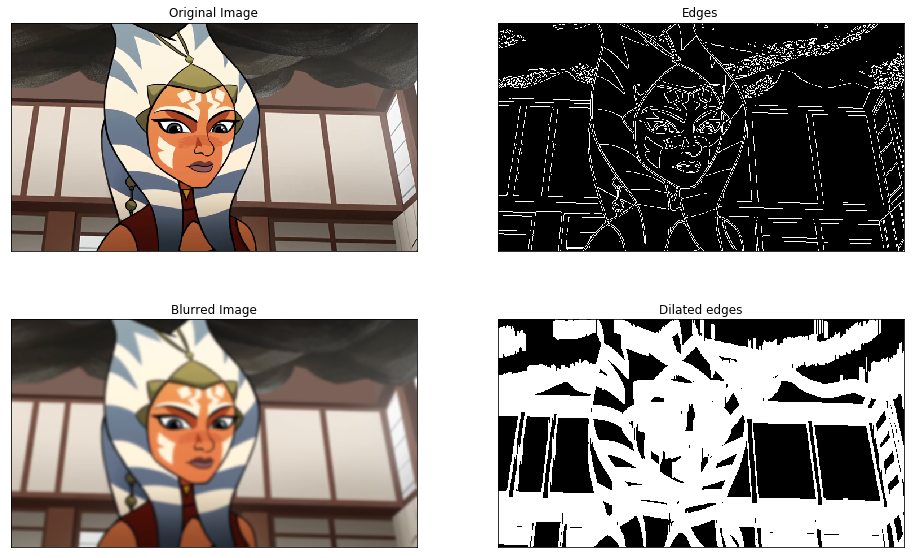

In [5]:
samples = os.listdir(os.path.join(COMIC_IMG_DIR, 'all'))
random.shuffle(samples)

sample = cv2.imread(os.path.join(COMIC_IMG_DIR, 'all', samples[0]))
result = smooth_image_edges(sample, plot=True)


### Prepare dataset:

In [6]:
# for img_name in os.listdir(os.path.join(COMIC_IMG_DIR, 'all')):
#     image = cv2.imread(os.path.join(COMIC_IMG_DIR, 'all', img_name))
#     result = smooth_image_edges(image, plot=False)
#     cv2.imwrite(os.path.join(COMIC_BLURRED_IMG_DIR, 'all', img_name), result)

# 2. Split dataset to training, validation and testing

In [7]:
# all_coco_images_names = os.listdir(os.path.join(REAL_IMG_DIR, 'all'))
# all_comic_images_names = os.listdir(os.path.join(COMIC_IMG_DIR, 'all')) 
# all_comic_blurred_images_names = os.listdir(os.path.join(COMIC_BLURRED_IMG_DIR, 'all')) 

# random.shuffle(all_coco_images_names)
# random.shuffle(all_comic_images_names)
# random.shuffle(all_comic_blurred_images_names)
# 
# # COCO REAL IMAGES
# # Copy 5k images from COCO as test dataset
# for img_name in all_coco_images_names[:NUMBER_OF_TEST_REAL_IMAGES]:
#     shutil.copy(os.path.join(REAL_IMG_DIR, 'all', img_name), 
#                 os.path.join(REAL_IMG_DIR, 'test', img_name))

# # Copy 5k images from COCO as validation dataset
# for img_name in all_coco_images_names[:NUMBER_OF_VALIDATION_REAL_IMAGES]:
#     shutil.copy(os.path.join(REAL_IMG_DIR, 'all', img_name), 
#                 os.path.join(REAL_IMG_DIR, 'validation', img_name))

# # Copy all reamaining images from COCO dataset as train datset
# for img_name in all_coco_images_names[NUMBER_OF_TEST_REAL_IMAGES:]:
#     shutil.copy(os.path.join(REAL_IMG_DIR, 'all', img_name), 
#                 os.path.join(REAL_IMG_DIR, 'train', img_name))
#     
#     
# # COMIC IMAGES  
# # Copy 1k images from COMIC as validation dataset
# for img_name in all_comic_images_names[:NUMBER_OF_VALIDATION_COMIC_IMAGES]:
#     shutil.copy(os.path.join(COMIC_IMG_DIR, 'all', img_name), 
#                 os.path.join(COMIC_IMG_DIR, 'validation', img_name))

# # Copy all reamaining images from COMIC as train dataset
# for img_name in all_comic_images_names[NUMBER_OF_VALIDATION_COMIC_IMAGES:]:
#     shutil.copy(os.path.join(COMIC_IMG_DIR, 'all', img_name), 
#                 os.path.join(COMIC_IMG_DIR, 'train', img_name))
    
    
# # COMIC BLURRED IMAGES 
# # Copy 1k validation images from COMIC BLURRED as validation dataset
# for img_name in all_comic_blurred_images_names[:NUMBER_OF_VALIDATION_COMIC_BLURRED_IMAGES]:
#     shutil.copy(os.path.join(COMIC_BLURRED_IMG_DIR, 'all', img_name), 
#                 os.path.join(COMIC_BLURRED_IMG_DIR, 'validation', img_name))

# # Copy all reamaining images from COMIC BLURRED as train dataset
# for img_name in all_comic_blurred_images_names[NUMBER_OF_VALIDATION_COMIC_IMAGES:]:
#     shutil.copy(os.path.join(COMIC_BLURRED_IMG_DIR, 'all', img_name), 
#                 os.path.join(COMIC_BLURRED_IMG_DIR, 'train', img_name))
    


In [8]:
def resize_image_with_crop(img, size=IMG_SIZE):
    h, w, _ = img.shape
    
    if w > h:
        new_h = size
        new_w = int(size * w / h)
        resized_img = cv2.resize(img, (new_w, new_h))
        r = random.randint(0, new_w-size)
        resized_img = resized_img[:size,r:r+size]
    else:
        new_w = size
        new_h = int(size * h / w)
        resized_img = cv2.resize(img, (new_w, new_h))
        r = random.randint(0, new_h-size)
        resized_img = resized_img[r:r+size,:size]
        
    return resized_img

In [9]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [10]:
def prepare_adv_dis_separate_image_batch(data_type='real', sub_dir='train', batch_size=BATCH_SIZE, generator_net=None):
    result_images, result_labels = [], []
    
    if data_type == 'real':
        img_dir = REAL_IMG_DIR
        
    elif data_type == 'comic':
        img_dir = COMIC_IMG_DIR
        
    elif data_type == 'comic_blur':
        img_dir = COMIC_BLURRED_IMG_DIR
        
    for img_name in random.sample(os.listdir(os.path.join(img_dir, sub_dir)), batch_size):
        img = cv2.imread(os.path.join(img_dir, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)

        if data_type == 'comic': 
            label = 0.0 * np.random.rand(int(IMG_SIZE/4), int(IMG_SIZE/4), 1) + 1.0
            label = np.where(label < 0.805, label - 0.6, label)
        else:
            label = 0.0 * np.random.rand(int(IMG_SIZE/4), int(IMG_SIZE/4), 1)
            label = np.where(label > 0.195, label + 0.6, label)            
        
        result_images.append(img)
        result_labels.append(label)
        
    batch_of_images = 2 * (np.stack(result_images, 0) / 255.0) - 1
    batch_of_labels = np.array(result_labels)
    
    if generator_net is not None and data_type == 'real':
        batch_of_images = generator_net.predict(batch_of_images)
    
    gc.collect()
    return batch_of_images, batch_of_labels

In [11]:
def prepare_adv_dis_image_batch(sub_dir='train', batch_size=BATCH_SIZE, generator_net=None):
    result_images, result_labels = [], []
    
    for img_name in random.sample(os.listdir(os.path.join(COMIC_IMG_DIR, sub_dir)), int(batch_size/2)):
        img = cv2.imread(os.path.join(COMIC_IMG_DIR, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)

        label = np.ones((int(IMG_SIZE/4), int(IMG_SIZE/4), 1))
        
        result_images.append(img)
        result_labels.append(label)
        
    for img_name in random.sample(os.listdir(os.path.join(COMIC_BLURRED_IMG_DIR, sub_dir)), int(batch_size/4)):
        img = cv2.imread(os.path.join(COMIC_BLURRED_IMG_DIR, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)
        
        label = np.zeros((int(IMG_SIZE/4), int(IMG_SIZE/4), 1))

        result_images.append(img)
        result_labels.append(label)
        
    comic_and_blur_comic_images_batch = 2 * (np.stack(result_images, 0) / 255.0) - 1
    
    coco_images = []
    for img_name in random.sample(os.listdir(os.path.join(REAL_IMG_DIR, sub_dir)), int(batch_size/4)):
        img = cv2.imread(os.path.join(REAL_IMG_DIR, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)
        
        label = np.zeros((int(IMG_SIZE/4), int(IMG_SIZE/4), 1))

        coco_images.append(img)
        result_labels.append(label)
    
    coco_batch = 2 * (np.stack(coco_images, 0) / 255.0) - 1
    if generator_net is not None:
        generated_images = generator_net.predict(coco_batch)
    else:
        generated_images = coco_batch
    
    batch_of_images = np.concatenate([comic_and_blur_comic_images_batch, generated_images], 0)
    batch_of_labels = np.array(result_labels, dtype=int)
    
    randomize = np.arange(len(result_labels))
    np.random.shuffle(randomize)
    
    gc.collect()
    return batch_of_images[randomize], batch_of_labels[randomize]

def prepare_adv_gen_image_batch(sub_dir='train', batch_size=BATCH_SIZE):
    result_labels = []
    coco_images = []
    for img_name in random.sample(os.listdir(os.path.join(REAL_IMG_DIR, sub_dir)), batch_size):
        img = cv2.imread(os.path.join(REAL_IMG_DIR, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)
        label = np.ones((int(IMG_SIZE/4), int(IMG_SIZE/4), 1))
        coco_images.append(img)
        result_labels.append(label)
    
    batch_of_images = 2 * (np.stack(coco_images, 0) / 255.0) - 1
    batch_of_labels = np.array(result_labels, dtype=int)
    
    gc.collect()
    return batch_of_images, batch_of_labels

def prepare_content_gen_image_batch(sub_dir='train', batch_size=PRETRAIN_BATCH_SIZE, vgg=None):
    coco_images = []
    
    for img_name in random.sample(os.listdir(os.path.join(REAL_IMG_DIR, sub_dir)), batch_size):
        img = cv2.imread(os.path.join(REAL_IMG_DIR, sub_dir, img_name))
        img = resize_image_with_crop(img, IMG_SIZE)
        coco_images.append(img)
    
    coco_batch = 2 * (np.stack(coco_images, 0) / 255.0) - 1
    
    if vgg is not None:
        feature_maps = vgg.predict(coco_batch)
    else:
        feature_maps = coco_batch
    
    gc.collect()
    return coco_batch, feature_maps

    

#### Let's plot some sample batches to see if it works properly:

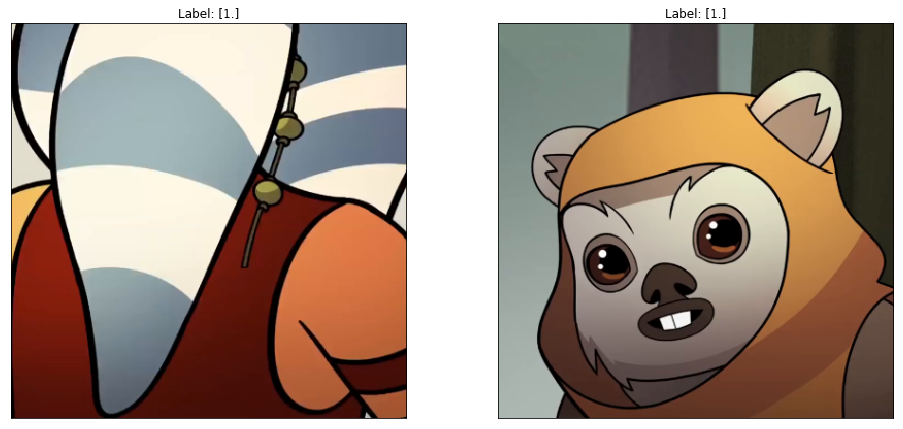

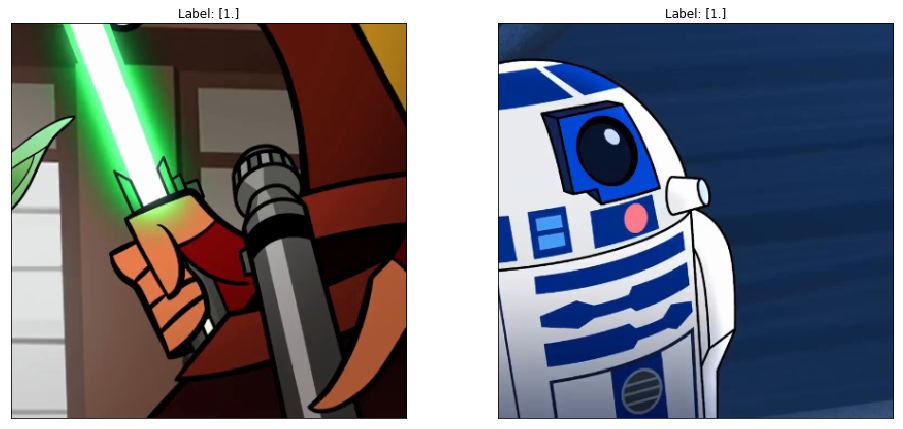

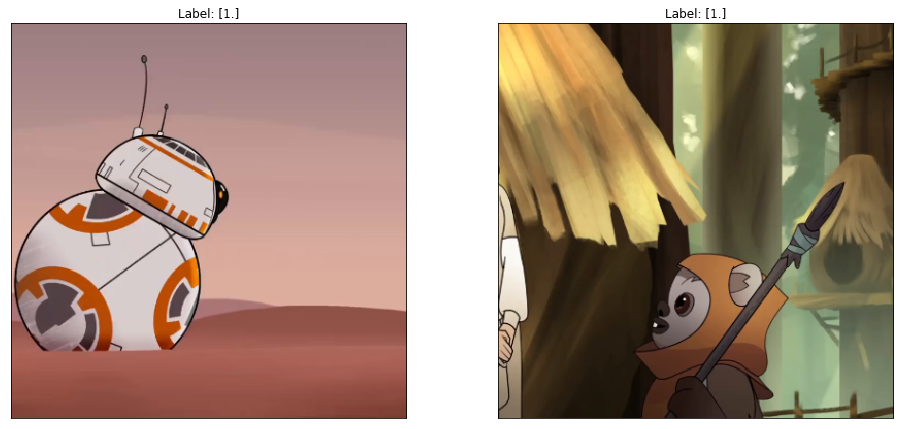

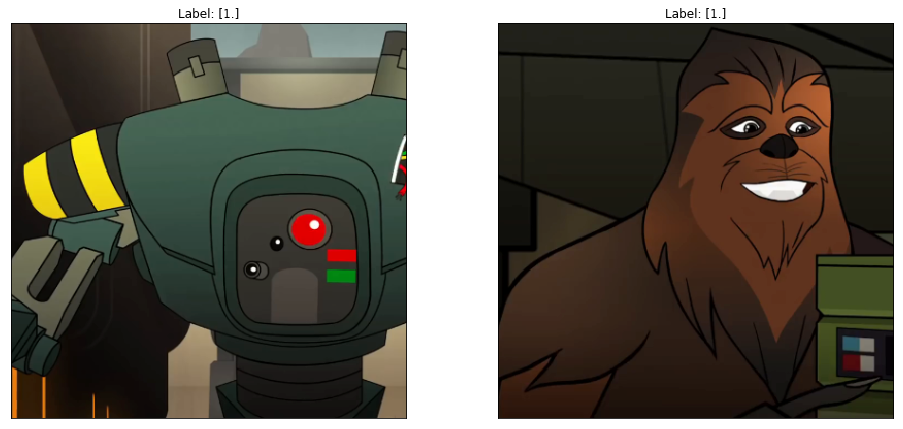

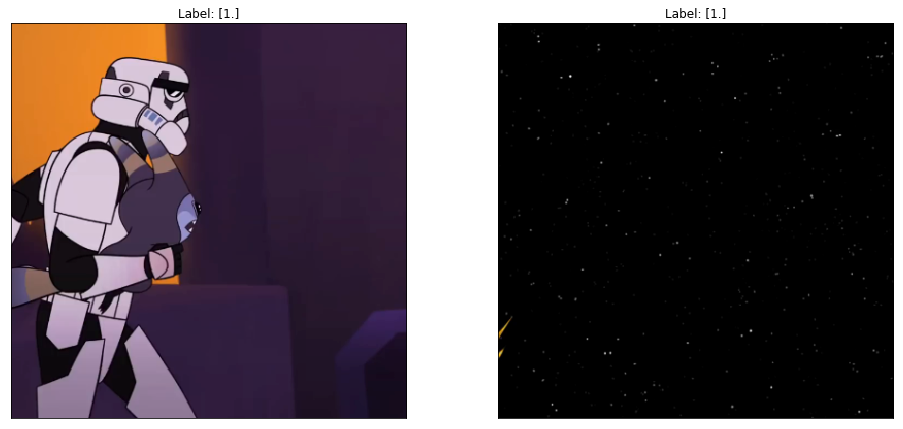

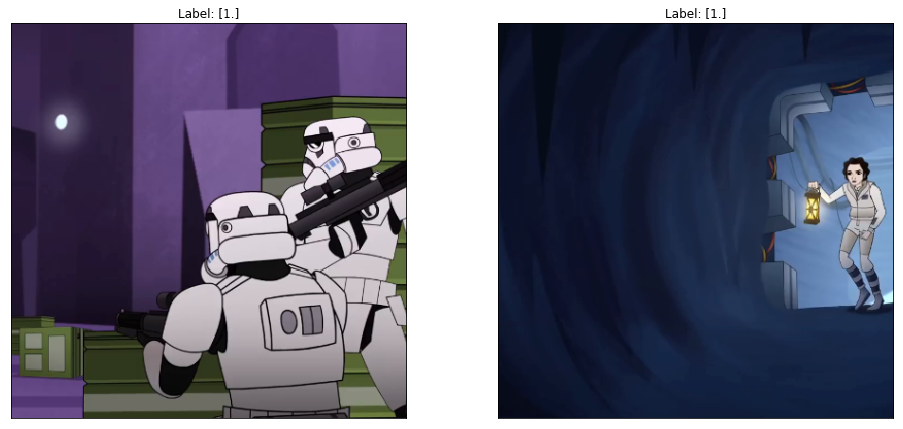

In [12]:
img_batch, labels  = prepare_adv_dis_separate_image_batch(data_type='comic', sub_dir='train', batch_size=12)

img_batch += 1
img_batch /= 2

for i in range(0, 12, 2):
    plt.figure(figsize=(16,16))
    plt.subplot(221),plt.imshow(img_batch[i][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i][0][0])), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(img_batch[i+1][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i+1][0][0])), plt.xticks([]), plt.yticks([])
    plt.show()



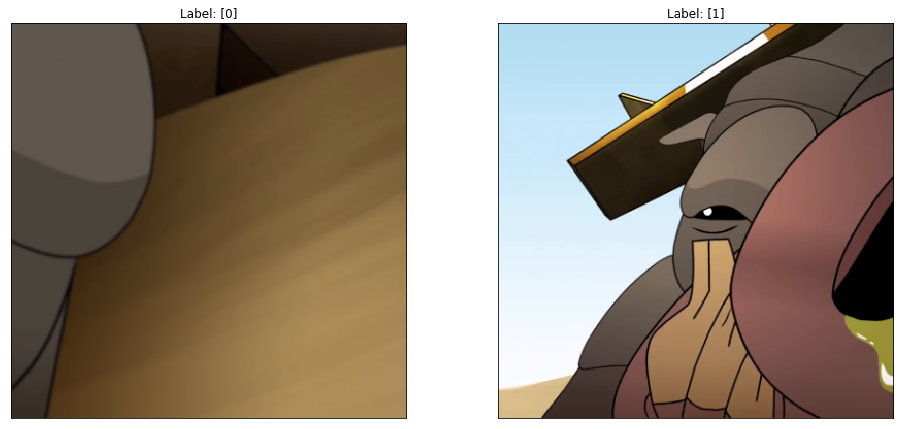

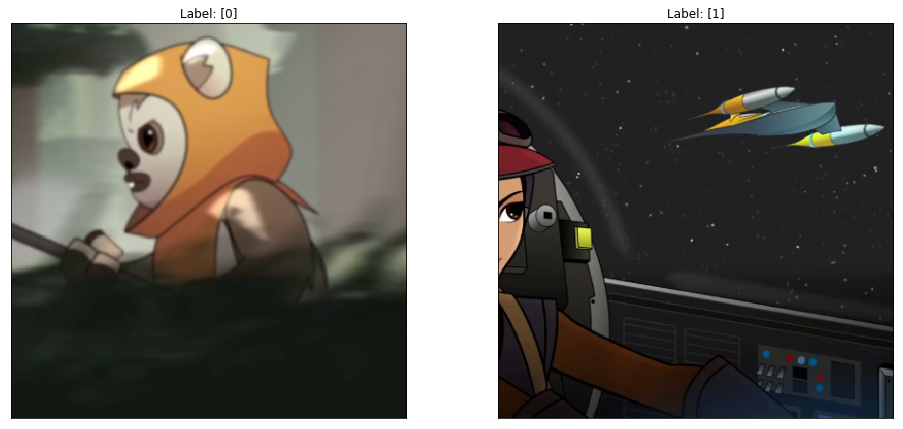

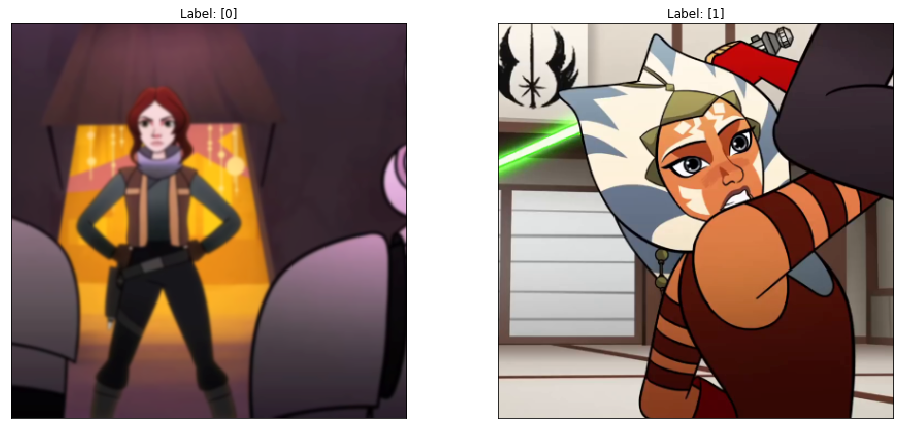

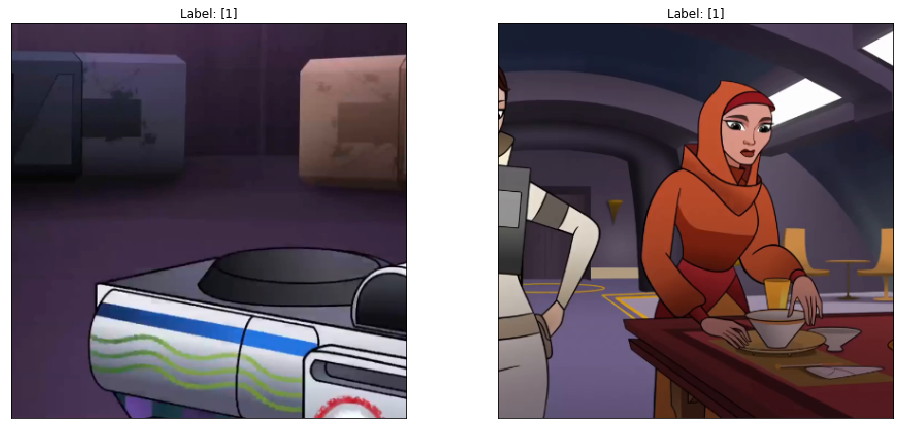

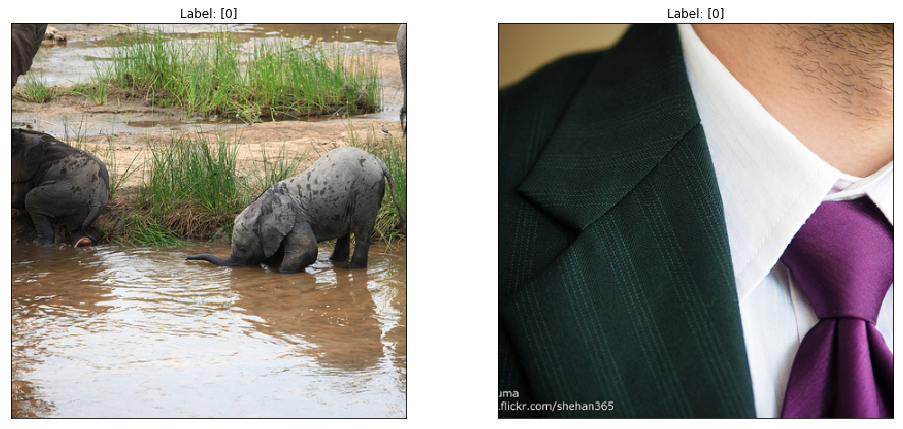

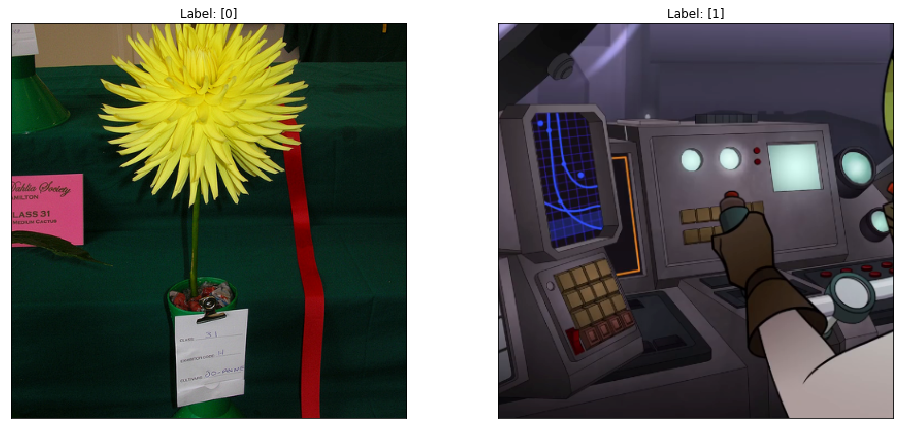

In [13]:
img_batch, labels = prepare_adv_dis_image_batch(sub_dir='train', batch_size=12)

img_batch += 1
img_batch /= 2

for i in range(0, 12, 2):
    plt.figure(figsize=(16,16))
    plt.subplot(221),plt.imshow(img_batch[i][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i][0][0])), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(img_batch[i+1][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i+1][0][0])), plt.xticks([]), plt.yticks([])
    plt.show()



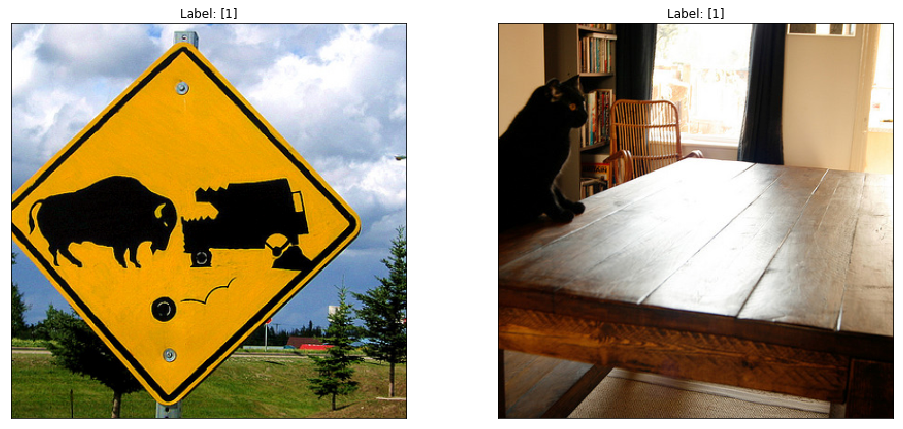

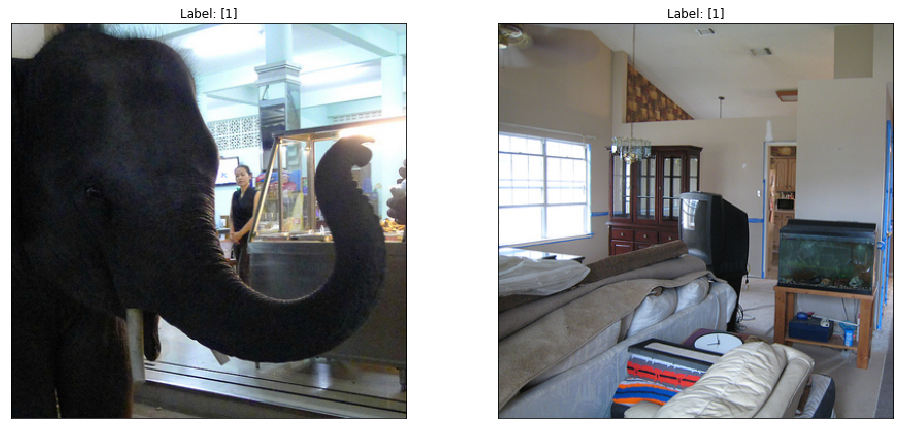

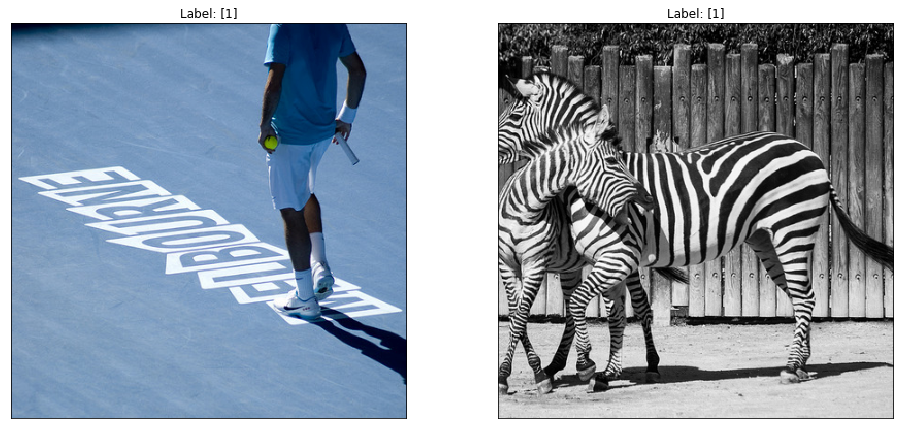

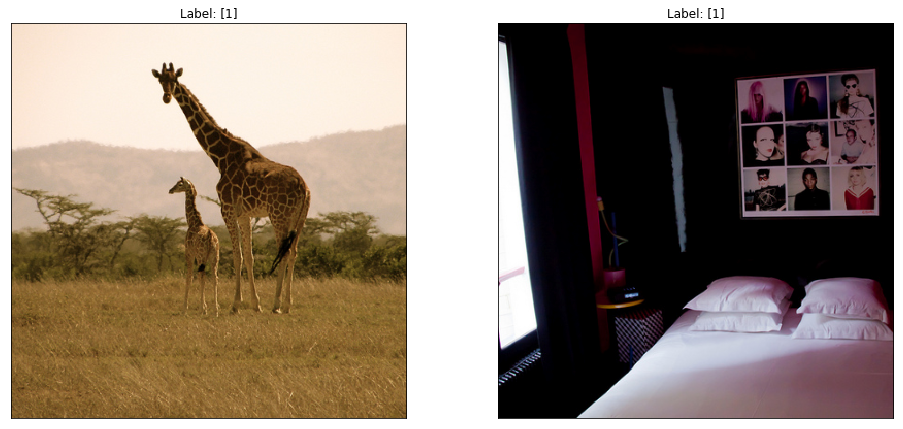

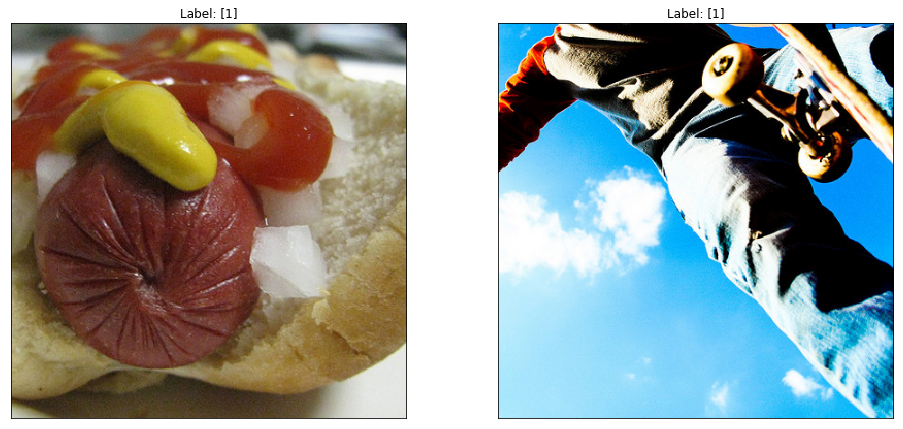

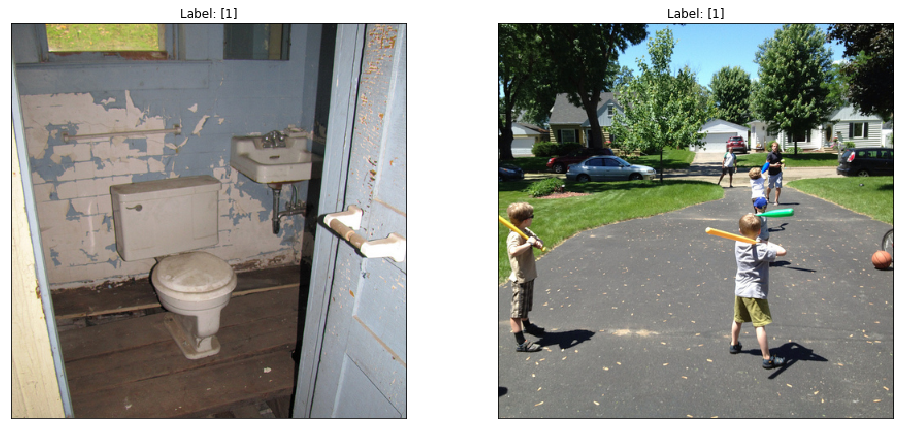

In [14]:
img_batch, labels  = prepare_adv_gen_image_batch(sub_dir='train', batch_size=12)

img_batch += 1
img_batch /= 2

for i in range(0, 12, 2):
    plt.figure(figsize=(16,16))
    plt.subplot(221),plt.imshow(img_batch[i][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i][0][0])), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(img_batch[i+1][:,:,[2,1,0]])
    plt.title('Label: {}'.format(labels[i+1][0][0])), plt.xticks([]), plt.yticks([])
    plt.show()



# 3. Models

In [15]:
def load_weights_if_possible(model, weights_path):
    try:
        model.load_weights(weights_path)
        print('Weights loaded!')
    except OSError:
        print('No file with weights available! Starting from scratch...')

In [16]:
def perceptual_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_DIM)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def perceptual_L1_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_DIM)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)
    loss_model.trainable = False
    return 10 * K.mean(K.abs(loss_model(y_true) - loss_model(y_pred)))

def L1_loss(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    return  10 * K.mean(x)

def boosted_binary_crossentropy(y_true, y_pred):
    return 10 * K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

def L1_loss_metric(y_true, y_pred):
    x = np.abs(y_true - y_pred)
    return  10 * np.mean(x)    

def binary_crossentropy_metric(y_true, y_pred):
    eps = 1e-12
    y_pred=np.clip(y_pred, eps, 1.0-eps)
    return - np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

def boosted_binary_crossentropy_metric(y_true, y_pred):
    eps = 1e-12
    y_pred=np.clip(y_pred, eps, 1.0-eps)
    return - 10 * np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

def binary_accuracy_metric(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5,1,0)
    y_pred = y_pred.astype(np.int32)
    return np.mean(np.equal(y_true, y_pred))



In [17]:
class DCGAN():   
    def __init__(self):
        optimizer = Adam(LEARNING_RATE, decay=0.00000001)
        self.pretrain_generator_history = []
        self.adversarial_history = []
        self.pretrain_discriminator_history = []

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.discriminator.summary()
        
        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.summary()
        
        input_image = layers.Input((None,None,3))
        
        self.discriminator.trainable = False
        
        generated_image = self.generator(input_image)
        combined = self.discriminator(generated_image)
        self.combined = Model(inputs=input_image, outputs=[generated_image, combined])
        
        self.combined.compile(loss=[perceptual_L1_loss, 'binary_crossentropy'],
                              loss_weights=[1, 1],
                              optimizer=optimizer)
        self.combined.summary()  

        vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_DIM)
        self.vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)
        
        inp2 = layers.Input((None,None,3))
        
        self.vgg_model.trainable = False        
        content_model = self.vgg_model(self.generator(inp2))
        self.content_model = Model(inputs=inp2, outputs=content_model)
        self.content_model.compile(loss=L1_loss, optimizer=optimizer)
        self.content_model.summary()
    
        
    def build_generator(self):
        def residual_block(input_tensor):
            c1 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(input_tensor)
            bn1 = InstanceNormalization(axis=3)(c1)
            a1 = layers.Activation('relu')(bn1) 
            c2 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(a1)
            bn2 = InstanceNormalization(axis=3)(c2)
            add1 = layers.add([bn2, input_tensor])
            
            return add1    
        
        inp = layers.Input((None,None,3))
        
        c1 = layers.Conv2D(64, (7, 7), strides=(1, 1), padding='same', use_bias=False)(inp)
        bn1 = InstanceNormalization(axis=3)(c1)
        a1 = layers.Activation('relu')(bn1)
        
        c2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(a1)
        c3 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(c2)
        bn2 = InstanceNormalization(axis=3)(c3)
        a2 = layers.Activation('relu')(bn2)
        
        c4 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(a2)
        c5 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(c4)
        bn3 = InstanceNormalization(axis=3)(c5)
        a3 = layers.Activation('relu')(bn3)
        
        r1 = residual_block(a3)
        r2 = residual_block(r1)
        r3 = residual_block(r2)
        r4 = residual_block(r3)
        r5 = residual_block(r4)
        r6 = residual_block(r5)
        r7 = residual_block(r6)
        r8 = residual_block(r7)
        
        u1 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same')(r8)
#         u1 = layers.UpSampling2D(size=(2, 2))(r8)
        c6 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(u1)
        bn4 = InstanceNormalization(axis=3)(c6)
        a4 = layers.Activation('relu')(bn4)
        
        u2 = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(a4)
#         u2 = layers.UpSampling2D(size=(2, 2))(a4)
        c7 = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(u2)
        bn5 = InstanceNormalization(axis=3)(c7)
        a5 = layers.Activation('relu')(bn5)
        
        output = layers.Conv2D(3, (7, 7), strides=(1, 1), activation='tanh', padding='same')(a5)

        return Model(inputs=[inp], outputs=[output])


    def build_discriminator(self):
        inp = layers.Input(INPUT_DIM)

        c1 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=True)(inp)
        a1 = layers.Activation(LeakyReLU(alpha=0.2))(c1)

        c2 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', use_bias=True)(a1)
        a2 = layers.Activation(LeakyReLU(alpha=0.2))(c2)
        
        c3 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(a2)
        bn1 = InstanceNormalization(axis=3)(c3)
        a3 = layers.Activation(LeakyReLU(alpha=0.2))(bn1)
        
        c4 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=True)(a3)
        a4 = layers.Activation(LeakyReLU(alpha=0.2))(c4)
        
        c5 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(a4)
        bn2 = InstanceNormalization(axis=3)(c5)
        a5 = layers.Activation(LeakyReLU(alpha=0.2))(bn2)
        
        c6 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(a5)
        bn3 = InstanceNormalization(axis=3)(c6)
        a6 = layers.Activation(LeakyReLU(alpha=0.2))(bn3)
        
        c7 = layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', use_bias=True)(a6)
#         fl = layers.Flatten()(c7)
#         output = layers.Dense(1, activation='sigmoid')(fl)

        return Model(inputs=[inp], outputs=[c7])

    def control_plot(self, epoch, pretrain=False):
        sample = cv2.imread(os.path.join(REAL_IMG_DIR, 'validation', '000000001735.jpg'))
        sample = resize_image_with_crop(sample, IMG_SIZE) / 255.0

        plt.figure(figsize=(16,16))
        plt.subplot(221),plt.imshow(sample[:,:,[2,1,0]])
        sample = np.expand_dims(sample, axis=0)
        sample = 2 * sample - 1        
        predicted_sample = self.generator.predict(sample)
        predicted_sample /= 2
        predicted_sample += 0.5
        
        directory = PRETRAIN_FIT_HISTORY_IMGS if pretrain else ADV_FIT_HISTORY_IMGS
        cv2.imwrite(os.path.join(directory, "{}.png".format(epoch)), 255*predicted_sample[0])
                    
        plt.subplot(222),plt.imshow(predicted_sample[0][:,:,[2,1,0]])
        plt.show()
        
    def show_pretrain_discriminator_loss_history(self):
        if not self.pretrain_discriminator_history:
            history_df= pd.read_csv(PRETRAIN_DISCRIMINATOR_FIT_HISTORY_PATH)
            self.pretrain_discriminator_history = [tuple(row) for row in history_df.values]
            
        t_loss  = [losses[0] for losses in self.pretrain_discriminator_history]
        v_loss  = [losses[1] for losses in self.pretrain_discriminator_history]
        epochs = range(len(self.pretrain_discriminator_history))
            
        fig, ax = plt.subplots(figsize=(22, 10))
        ax.plot(epochs, t_loss, 'b-')
        ax.plot(epochs, v_loss, 'r-')
        ax.legend(['Training', 'Validation'])
        ax.set_title('G pretrain Loss')
        plt.show()
        
    def show_pretrain_loss_history(self):
        if not self.pretrain_generator_history:
            history_df= pd.read_csv(PRETRAIN_FIT_HISTORY_PATH)
            self.pretrain_generator_history = [tuple(row) for row in history_df.values]
            
        t_loss  = [losses[0] for losses in self.pretrain_generator_history]
        v_loss  = [losses[1] for losses in self.pretrain_generator_history]
        epochs = range(len(self.pretrain_generator_history))
            
        fig, ax = plt.subplots(figsize=(22, 10))
        ax.plot(epochs, t_loss, 'b-')
        ax.plot(epochs, v_loss, 'r-')
        ax.legend(['Training', 'Validation'])
        ax.set_title('G pretrain Loss')
        plt.show()
        
    def show_adv_loss_history(self):
        if not self.adversarial_history:
            history_df= pd.read_csv(ADV_FIT_HISTORY_PATH)
            self.adversarial_history = [tuple(row) for row in history_df.values]
            
        d_t_loss  = [losses[0] for losses in self.adversarial_history]
        g_t_loss  = [losses[1] for losses in self.adversarial_history]
        d_v_loss  = [losses[2] for losses in self.adversarial_history]
        g_v_loss  = [losses[3] for losses in self.adversarial_history]
        epochs = range(len(self.adversarial_history))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

        ax1.plot(epochs, d_t_loss, 'b-', epochs, d_v_loss, 'r-')
        ax1.legend(['Training', 'Validation'])
        ax1.set_title('D Loss')

        ax2.plot(epochs, g_t_loss, 'b-', epochs, g_v_loss, 'r-')
        ax2.legend(['Training', 'Validation'])
        ax2.set_title('G Loss')
        plt.show()
        
    def pretrain_discriminator(self):     
        if LOAD_WEIGHTS_D:
            load_weights_if_possible(self.discriminator, D_PRETRAIN_WEIGHTS_PATH)
        
        # Prepare validation dataset:
        x_valid, y_valid_true = \
        prepare_adv_dis_image_batch(sub_dir='validation',
                                    batch_size=PRETRAIN_VALIDATION_IMGS_NUM_TO_USE)
        
        self.pretrain_discriminator_history = []
        for epoch in range(PRETRAIN_DISCRIMINATOR_MAX_TRAIN_EPOCHS):
            for step in range(MAX_TRAIN_STEPS):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                x_train, y_train_true = prepare_adv_dis_image_batch('train',
                                                                    batch_size=PRETRAIN_DISCRIMINATOR_BATCH_SIZE)
                t_loss = self.discriminator.train_on_batch(x_train,
                                                           y_train_true)
                print("Epoch {} | Step {} | Training Loss: {} | Acc: {}".format(epoch, step, t_loss[0], t_loss[1]))
                
            # Get validation metrics   
            y_valid_pred = self.discriminator.predict(x_valid)
            v_loss = binary_crossentropy_metric(y_valid_true, y_valid_pred)
            v_acc = binary_accuracy_metric(y_valid_true, y_valid_pred)
            print("\n(Validation) Epoch {} | Validation Loss: {} | Acc: {}\n".format(epoch, v_loss, v_acc))

            # Save weights if validation loss decrease
            if epoch > 0 and v_loss < min(self.pretrain_discriminator_history, key=lambda x: x[1])[1]:                                 
                self.discriminator.save_weights(D_PRETRAIN_WEIGHTS_PATH)
                print("Validation loss improved, saving model weights...")
            
            self.pretrain_discriminator_history.append((t_loss[0], v_loss))
            self.show_pretrain_discriminator_loss_history()
            
            history_df = pd.DataFrame(self.pretrain_discriminator_history)
            history_df.to_csv(PRETRAIN_DISCRIMINATOR_FIT_HISTORY_PATH, index=False)
            gc.collect() 
            

    def pretrain_generator(self):     
        if LOAD_WEIGHTS_G:
            load_weights_if_possible(self.generator, G_PRETRAIN_WEIGHTS_PATH)
        
        # Prepare validation dataset:
        x_valid, y_valid_true = \
        prepare_content_gen_image_batch('validation',
                                        batch_size = PRETRAIN_VALIDATION_IMGS_NUM_TO_USE,
                                        vgg=self.vgg_model)
        self.pretrain_generator_history = []
        for epoch in range(PRETRAIN_MAX_TRAIN_EPOCHS):
            for step in range(MAX_TRAIN_STEPS):
                # ---------------------
                #  Train Generator
                # ---------------------
                x_train, y_train_true = prepare_content_gen_image_batch('train',
                                                                        vgg=self.vgg_model)
                t_loss = self.content_model.train_on_batch(x_train,
                                                           y_train_true)
                print("Epoch {} | Step {} | Training Loss: {}".format(epoch, step, t_loss))
                
                gc.collect()
                
            # Get validation metrics   
            y_valid_pred = self.content_model.predict(x_valid)
            v_loss = L1_loss_metric(y_valid_true, y_valid_pred)
            print("\n(Validation) Epoch {} | Validation Loss: {}\n".format(epoch, v_loss))

            # Save weights if validation loss decrease
            if epoch > 0 and v_loss < min(self.pretrain_generator_history, key=lambda x: x[1])[1]:                                 
                self.generator.save_weights(G_PRETRAIN_WEIGHTS_PATH)
                print("Validation loss improved, saving model weights...")
            
            self.control_plot(epoch, pretrain=True)
                        
            self.pretrain_generator_history.append((t_loss, v_loss))
            self.show_pretrain_loss_history()
            gc.collect() 
            
            history_df = pd.DataFrame(self.pretrain_generator_history)
            history_df.to_csv(PRETRAIN_FIT_HISTORY_PATH, index=False)

    def adversarial_train(self):
        if LOAD_WEIGHTS_G:
            load_weights_if_possible(self.generator, G_PRETRAIN_WEIGHTS_PATH)
        if LOAD_WEIGHTS_D:
            load_weights_if_possible(self.discriminator, D_PRETRAIN_WEIGHTS_PATH)
                                                   
        # Prepare validation datasets:
                                                 
        g1_x_valid, g1_y_valid_true = \
        prepare_adv_gen_image_batch(sub_dir='validation',
                                    batch_size=ADVERSARIAL_VALIDATION_IMGS_NUM_TO_USE)
                                                   
        self.adversarial_history = []
        for epoch in range(MAX_TRAIN_EPOCHS):
            d_x_valid, d_y_valid_true = \
            prepare_adv_dis_image_batch(sub_dir='validation',
                                        batch_size=ADVERSARIAL_VALIDATION_IMGS_NUM_TO_USE,
                                        generator_net=self.generator)
            for step in range(MAX_TRAIN_STEPS):
                #  Train Discriminator                
                d_t_losses = []
                for data_type in ['real', 'comic', 'comic_blur']:
                    d_x_train, d_y_train_true = prepare_adv_dis_separate_image_batch(data_type=data_type,
                                                                                     sub_dir='train',
                                                                                     batch_size=BATCH_SIZE,
                                                                                     generator_net=self.generator)
                    d_t_loss = self.discriminator.train_on_batch(d_x_train, d_y_train_true)
                    d_t_losses.append(d_t_loss)
                    gc.collect()
                
                d_t_loss = sum(loss[0] for loss in d_t_losses) / 3
                
                
                for i in range(3):
                    #  Train Generator               
                    g1_x_train, g1_y_train_true = prepare_adv_gen_image_batch(sub_dir='train',
                                                                              batch_size=BATCH_SIZE)
                    g1_t_loss = self.combined.train_on_batch(g1_x_train, [g1_x_train, g1_y_train_true])               

                    g_t_loss = g1_t_loss[0] + g1_t_loss[1]
                    gc.collect()
                                                   
                # Plot the progress
                print("Epoch {} | Step {} \n"
                      "D. Adv. Train. Loss: {} \n"
                      "G. Adv. + Content Train. Loss: {} ({} {})|".format(epoch, step, d_t_loss,
                                                                          g_t_loss, g1_t_loss[0], g1_t_loss[1]))
                gc.collect()
                
            # Get validation metrics
            d_y_valid_pred = self.discriminator.predict(d_x_valid)
            g2_y_valid_pred, g1_y_valid_pred = self.combined.predict(g1_x_valid)
            
            d_v_loss = binary_crossentropy_metric(d_y_valid_true, d_y_valid_pred)
            d_v_acc = binary_accuracy_metric(d_y_valid_true, d_y_valid_pred)
            g1_v_loss = binary_crossentropy_metric(g1_y_valid_true, g1_y_valid_pred)                                       
            g2_v_loss = L1_loss_metric(g1_x_valid, g2_y_valid_pred)
            g_v_loss = g1_v_loss + g2_v_loss
            
            print("\n(Validation) Epoch {} \n"
                  "D. Adv. valid. Loss: {} | Acc.: {} \n"
                  "G. Adv. + Content valid. Loss: {} ({} {})|\n".format(epoch, d_v_loss, d_v_acc,
                                                                      g_v_loss, g1_v_loss, g2_v_loss))
                  
            # Save weights if validation loss decrease
            if epoch > 0 and g_v_loss < min(self.adversarial_history, key=lambda x: x[3])[3]:                                 
                self.generator.save_weights(G_WEIGHTS_PATH)
                print("Validation Generator loss improved, saving model weights...")
            if epoch > 0 and d_v_loss < min(self.adversarial_history, key=lambda x: x[2])[2]:                                  
                self.discriminator.save_weights(D_WEIGHTS_PATH)
                print("Validation Discriminator loss improved, saving model weights...")
            
            self.control_plot(epoch)
            
            self.adversarial_history.append((d_t_loss, g_t_loss, d_v_loss, g_v_loss))
            self.show_adv_loss_history()
            gc.collect()
            history_df = pd.DataFrame(self.adversarial_history)
            history_df.to_csv(ADV_FIT_HISTORY_PATH, index=False)
            
            if epoch > 50:
                self.generator.save_weights(os.path.join(CHECKPOINTS_DIR, "{}_G_weights.best.hdf5".format(epoch)))

dcgan = DCGAN()

/home/mpesko/projects/comixify/comixGAN/venv/lib/python3.5/site-packages/keras/activations.py:197: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73728     
_________________________________________________________________
instance_normalization_1 (In (None, None, None, 128)   256       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
model_2 (Model)              (None, None, None, 3)     11124931  
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     1129025   
Total params: 12,253,956
Trainable params: 11,124,931
Non-trainable params: 1,129,025
_________________________________________________________________


InternalError: Dst tensor is not initialized.
	 [[Node: _arg_Placeholder_9_0_31/_509 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_161__arg_Placeholder_9_0_31", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

# 4. Initial Training of Generator network

In [ ]:
dcgan.pretrain_generator()

In [ ]:
dcgan.show_pretrain_loss_history()

In [ ]:
# Load pretrained generator
# dcgan.generator.save_weights(G_PRETRAIN_WEIGHTS_PATH)
dcgan.generator.load_weights(G_PRETRAIN_WEIGHTS_PATH)

# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, 'good', "G_weights_pretrain.best.hdf5"))


#### Let's check if generator is already pretrained to return image the same to the input image

In [ ]:
samples = os.listdir(os.path.join(REAL_IMG_DIR, 'validation'))
random.shuffle(samples)
for image_name in samples[:5]:

    sample = cv2.imread(os.path.join(REAL_IMG_DIR, 'validation', image_name))
    sample = resize_image_with_crop(sample, IMG_SIZE) / 255.0

    plt.figure(figsize=(16,16))
    plt.subplot(221),plt.imshow(sample[:,:,[2,1,0]])
    sample = np.expand_dims(sample, axis=0)
    sample *= 2
    sample -= 1
    predicted_sample = dcgan.generator.predict(sample)
    predicted_sample += 1
    predicted_sample /= 2
    plt.subplot(222),plt.imshow(predicted_sample[0][:,:,[2,1,0]])
    plt.show()


In [ ]:
gc.collect()


# 5. Initial Training of Discriminator

In [ ]:
dcgan.pretrain_discriminator()

In [ ]:
dcgan.show_pretrain_discriminator_loss_history()

In [ ]:
dcgan.discriminator.load_weights(D_PRETRAIN_WEIGHTS_PATH)

# 6. Adversarial Training

In [ ]:
dcgan.adversarial_train()

In [ ]:
dcgan.show_adv_loss_history()

In [ ]:
# dcgan.generator.save_weights(G_WEIGHTS_PATH)
# dcgan.discriminator.save_weights(D_WEIGHTS_PATH)

#### Let's check some result from real validation dataset

In [ ]:
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "299_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "268_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "266_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "248_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "238_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "229_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "216_G_weights.best.hdf5"))
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "190_G_weights.best.hdf5"))



In [ ]:
# dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "cartoonGAN_results", "{}_G_weights.best.hdf5".format(238)))
# dcgan.generator.save(os.path.join(CHECKPOINTS_DIR, "comparison", "cartoon_gan.h5"))


In [ ]:
samples = os.listdir(os.path.join(REAL_IMG_DIR, 'test'))
random.shuffle(samples)
for image_name in samples[:10]:
    sample = cv2.imread(os.path.join(REAL_IMG_DIR, 'test', image_name)) / 255
    sample = resize_image_with_crop(sample, 450)
    sample = np.expand_dims(sample, axis=0)
    row = [sample[0]]
    for model_number in [181]:
        dcgan.generator.load_weights(os.path.join(CHECKPOINTS_DIR, "{}_G_weights.best.hdf5".format(model_number)))
        predicted_sample = dcgan.generator.predict(sample)
#         cv2.imwrite(os.path.join('examples', str(model_number), "{}_{}".format(model_number,image_name)), 255*predicted_sample[0])
        row.append(predicted_sample[0])
    plot_side_by_side(row)


In [ ]:
gc.collect()